100%|██████████| 1/1 [00:22<00:00, 22.69s/it]


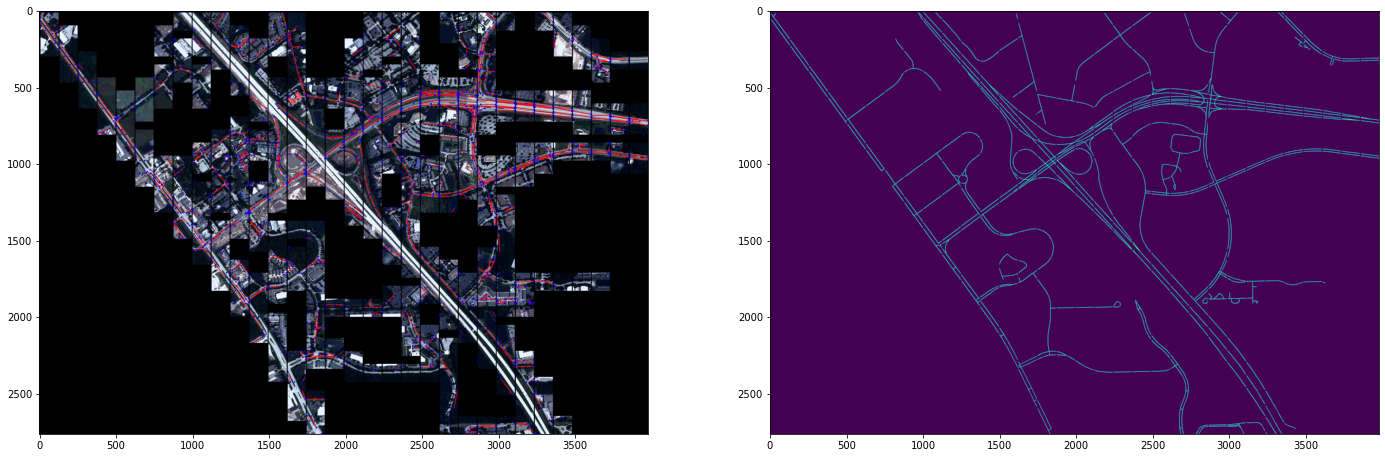

In [2]:
import os
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm


def scale_coordinates(coord, image_size, x0, y0):
    return int(coord[0] * image_size[0] + x0), int(coord[1] * image_size[1] + y0)

def to_img_and_seg_from_results(filelist, rootdir):
    p = 5

    # tot_img = np.zeros((2048, 2048, 3))
    # tot_seg = np.zeros((2048, 2048, 1))
    # tot_dat = np.zeros((2048, 2048, 1))
    tot_img = np.zeros((2762, 3977, 3))
    tot_seg = np.zeros((2762, 3977, 1))
    tot_dat = np.zeros((2762, 3977, 1))

    for filename in filelist:
        img = np.array(Image.open(os.path.join(rootdir, 'patch', filename)))
        seg = np.array(Image.open(os.path.join(rootdir, 'seg', filename)))

        x0 = int(filename.split('_')[1])
        y0 = int(filename.split('_')[2])

        # print(x0, y0)
        tot_img[x0+p:x0+128-p, y0+p:y0+128-p] = img[p:-p,p:-p]
        tot_seg[x0+p:x0+128-p, y0+p:y0+128-p] += seg[p:-p,p:-p,np.newaxis]
        tot_dat[x0+p:x0+128-p, y0+p:y0+128-p] += 1

    tot_dat[tot_dat == 0] = 1
    tot_seg = tot_seg / tot_dat
    tot_seg = tot_seg.astype('uint8')
    tot_img = tot_img.astype('uint8')
    return tot_seg, tot_img


def to_graph_from_results(tot_img, filelist, rootdir):
    image_size=(128,128)
    # blank_image = np.ones((2048,2048, 3), dtype='uint8') * 255
    blank_image = tot_img.copy()
    for filename in filelist:
        with open(os.path.join(rootdir, 'graph', filename)) as f:
            data = json.load(f)

        # if filename == 'data.json':
        #     continue

        x0 = int(filename.split('_')[1])
        y0 = int(filename.split('_')[2])

        nodes = data['pred_node']
        edges = data['pred_edge']

        for edge in edges:
            node1 = scale_coordinates(nodes[edge[0]], image_size, x0, y0)
            node2 = scale_coordinates(nodes[edge[1]], image_size, x0, y0)
            cv2.line(blank_image, node1[::-1], node2[::-1], (255, 0, 0), 3) 

        for node in nodes:
            scaled_node = scale_coordinates(node, image_size, x0, y0)
            cv2.circle(blank_image, scaled_node[::-1], 5, (0, 0, 255), -1) 

    blank_image = blank_image.astype('uint8')
    return blank_image


if __name__ == "__main__":

    # rootdir = '/nas/tsgil/relationformer/gil/test_data_region/'
    rootdir = '/nas/tsgil/relationformer/gil/spacenet_test_data_region'
    # rootdir = '/nas/tsgil/relationformer/gil/test_single_data_region' # test-single
    filelist_p = os.listdir(os.path.join(rootdir, 'patch'))
    filelist_g = os.listdir(os.path.join(rootdir, 'graph'))

    # region_num_list = [8,9,19,28,29,39,48,49,59,68,69,79,88,89,99,108,109,119,128,129,139,148,149,159,168,169,179]
    # region_num_list = ['05JUL15WV031100015JUL05162954']
    with open("/nas/tsgil/relationformer/data/spacenet3/data_split.json", "r") as file:
        split_info = json.load(file)
    region_num_list = ['-'.join(x.split('_')[1:]) for x in split_info['test']]

    for region_num in tqdm(region_num_list): # 22.61s/it
        # print(region_num)
        tmp = []
        for a in filelist_p:
            if int(a.split('.')[0].split('_')[-1]) == region_num:
            # if a.split('.')[0].split('_')[-1] == region_num: # test-single
                tmp.append(a)
        filelist_p_region = tmp
        tmp = []
        for b in filelist_g:
            if int(b.split('.')[0].split('_')[-1]) == region_num:
            # if b.split('.')[0].split('_')[-1] == region_num: # test-single
                tmp.append(b)
        filelist_g_region = tmp
        # print(len(filelist_p_region),len(filelist_g_region))
        tot_seg, tot_img = to_img_and_seg_from_results(filelist_p_region, rootdir)
        tot_graph = to_graph_from_results(tot_img, filelist_g_region, rootdir)

        fig, ax = plt.subplots(1, 2, figsize=(24,12))
        # fig, ax = plt.subplots(2, 1, figsize=(18,36))
        ax[0].imshow(tot_graph)
        ax[1].imshow(tot_seg)
        save_dir = f'/nas/tsgil/relationformer/inference_plt/{region_num}'
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        plt.savefig(f'/nas/tsgil/relationformer/inference_plt/{region_num}/result.png', dpi=400, facecolor='#eeeeee')
        # plt.show()
